In [1]:
import torch
%matplotlib inline
import PIL
import keras 
import skimage
from PIL import Image
from torch import nn, optim
from keras.layers import Lambda, Input, Dense
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
from zipfile import ZipFile
# from io import BytesIO
from skimage import data
from skimage import io
from skimage.color import rgb2gray
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from IPython.display import display
from skimage.io import imread_collection
from keras.models import load_model
import h5py

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
seq = imread_collection("test/*.jpg", conserve_memory=True)

/datasets/home/41/741/mpoori/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/datasets/home/41/741/mpoori/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


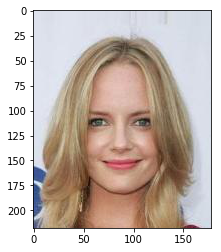

In [3]:
images = np.zeros((10, 56, 56, 1))
for i in range(10):
    image = skimage.transform.resize(seq[i], (56, 56, 3))
    images[i,:,:,0]= rgb2gray(image)
    
N = 10

img = seq[0]
imgplot = plt.imshow(img)

images_i = np.zeros((N, seq[0].shape[0], seq[0].shape[1], 1))
x_test = np.zeros((N, 56,56,1))
x_test_gan = np.zeros((N, 32,32,3))
x_test_vae = np.zeros((N, 28,28,1))
for i in range(N):
    image = seq[i]
    images_i[i,:,:,0]= rgb2gray(image)
    x_test[i] = skimage.transform.resize(images_i[i], (56,56,1))
    x_test_vae[i] = skimage.transform.resize(images_i[i], (28,28,1))
    x_test_gan[i] = skimage.transform.resize(image, (32,32,3))
imgplot = plt.imshow(image)

In [4]:
class Generator_CNN(nn.Module):
    def __init__(self):
        super(Generator_CNN, self).__init__()
        self.g_conv_n32s1_f = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_5 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n32s1_6 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.g_conv_n1s1 = nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, img):
        out = self.relu(self.g_conv_n32s1_f(img))
        out = self.relu(self.g_conv_n32s1_1(out))
        out = self.relu(self.g_conv_n32s1_2(out))
        out = self.relu(self.g_conv_n32s1_3(out))
        out = self.relu(self.g_conv_n32s1_4(out))
        out = self.relu(self.g_conv_n32s1_5(out))
        out = self.relu(self.g_conv_n32s1_6(out))
        out = self.relu(self.g_conv_n1s1(out)) 
        return out

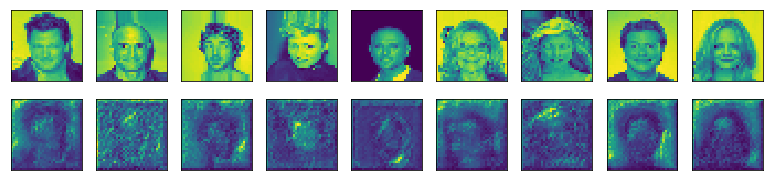

In [5]:
x_ctest = np.moveaxis(x_test_gan, [0,1,2,3], [0,2,3,1])
noise_factor = 0.1
x_test_noisy = x_ctest + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_ctest.shape) 
model = Generator_CNN()
model.load_state_dict(torch.load('wgan_weights'))
#p = model(torch.Tensor(x_test_noisy))
p=model((torch.Tensor(x_test_noisy)*2-1)*100)
a = p.data.numpy()
a = np.moveaxis(a,[0,1,2,3],[0,3,1,2])
x_test_noisy = np.moveaxis(x_ctest,[0,1,2,3],[0,3,1,2])
n = 10
plt.figure(figsize=(15,3))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(rgb2gray(x_test_noisy[i,:,:,:]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display GAN outputs
    ax = plt.subplot(2, n, i+n)
    plt.imshow(rgb2gray(a[i,:,:,:]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()